In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta

In [2]:
df = pd.read_csv('./processed_data.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,AO_5_34,APO_12_26,BIAS_SMA_26,...,STOCHk_14_3_3,STOCHd_14_3_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14
0,2016-07-21,1631.666626,1631.666626,1593.333374,1605.000000,1454.140381,25800,-1,-1,-1,...,-1,-1,-1,-1,1,1,-1,-1,-1,-1
1,2016-07-22,1608.333374,1628.333374,1603.333374,1603.333374,1452.630615,11700,-1,-1,-1,...,1,-1,0,-1,1,1,-1,-1,-1,-1
2,2016-07-25,1633.333374,1635.000000,1600.000000,1600.000000,1449.610474,22200,-1,-1,-1,...,-1,-1,-1,-1,1,1,-1,-1,-1,-1
3,2016-07-26,1631.666626,1665.000000,1616.666626,1663.333374,1506.990845,32700,1,-1,-1,...,1,1,1,1,1,1,1,-1,1,1
4,2016-07-27,1670.000000,1710.000000,1670.000000,1706.666626,1546.251099,30900,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,2022-08-03,12170.000000,12170.000000,11840.000000,12050.000000,12050.000000,96700,1,1,1,...,1,1,1,1,-1,-1,1,1,1,1
1495,2022-08-04,12250.000000,12640.000000,12100.000000,12540.000000,12540.000000,89200,1,1,1,...,1,1,1,1,-1,-1,1,1,1,1
1496,2022-08-05,12650.000000,12780.000000,12350.000000,12500.000000,12500.000000,86000,1,1,1,...,1,1,1,1,1,-1,1,1,-1,-1
1497,2022-08-08,12350.000000,12470.000000,12060.000000,12320.000000,12320.000000,122900,1,1,1,...,-1,-1,-1,-1,1,-1,1,1,1,-1


In [3]:
def splitData(arr):
    train_count = round(0.8 * len(arr))
    val_count = round(0.1 * len(arr))
    return arr[:train_count], arr[train_count:train_count+val_count], arr[train_count+val_count:]

In [4]:
# df, df_val, df_test = splitData(df)

In [5]:
def getBestColumns(df, horizon = 1):
    price = df["Adj Close"]
    perf = []
    for col in df.columns[7:]:
        good, bad = 0, 0
        total = 0
        for samp in [0.6, 0.8, 1]:
            samp = round(samp * len(df)) + horizon
            start = max(len(df)-horizon-samp, 0)
            for i in range(start, len(df)-horizon):
                if df[col][i] == 1 and price[i] <= price[i+horizon]:
                    good +=1
                elif df[col][i] == -1 and price[i] >= price[i+horizon]:
                    good +=1
                total+=1
            
        perf.append((good/total, col))

    perf = sorted(perf, reverse=True)
    best_cols = [colName for score, colName in perf]
    best_cols = best_cols[:min(22,len(best_cols))]
    return best_cols

# Filter out best columns based on training data
# best_cols = getBestColumns(df)
# print(best_cols, len(best_cols))

In [6]:
def colNamesToArr(colNames, df):
    return np.array([df[col].to_numpy() for col in colNames]).T

def addOne(arr):
    for i in range(len(arr)):
        if arr[i] == 0:
            arr[i] = 1
            break
        elif arr[i] == 1:
            arr[i] = 0
def scoreCombinations(df, colNames, horizon = 1):
    arr, prices = colNamesToArr(colNames, df), df["Adj Close"].to_numpy()
    mask = np.zeros(len(colNames), dtype=np.int32)
    true = []

    for i in range(len(prices)-horizon):
        if prices[i] < prices[i+horizon]:
            true.append(1)
        else:
            true.append(-1)

    true = np.array(true)
#     print(arr.shape)
    slicedArr = arr[:len(true),:]
    bestScore = 0
    bestSubset = np.copy(mask)
    bestBySize = {}
#     print(true.shape)
    for i in range(2 ** len(colNames)):
        addOne(mask)   
        if np.sum(mask) % 2 == 0:
            continue
        prod = slicedArr @ mask
        prod = np.clip(prod, -1, 1)
        correct = np.sum(prod == true)
        score = correct / np.count_nonzero(prod)
        if score > bestScore:
            print("Best so far", score, repr(mask))
            bestScore = score
            bestSubset = np.copy(mask)
                
    return bestScore, bestSubset

# _, test_mask = scoreCombinations(df, best_cols)
# print("Done")

In [7]:
def testCombo(mask, df, colNames, horizon = 1):
    arr, prices = colNamesToArr(colNames, df), df["Adj Close"].to_numpy()
    pred = arr @ mask
    pred = np.clip(pred, -1, 1)[:-1]
    true = []
    for i in range(len(prices)-1):
        if prices[i] < prices[i+horizon]:
            true.append(1)
        else:
            true.append(-1)
 
    true = np.array(true)
#     print(np.unique(true, return_counts=True))
    correct = np.sum(pred == true)
    score = correct / np.count_nonzero(pred)
        
    return score

In [8]:
# using = []
# for mask, colName in zip(test_mask, best_cols):
#     if mask == 1:
#         using.append(colName)
# print("Combining momentum predictions from", using)
# print("Test:", testCombo(test_mask, df_test, best_cols))

In [9]:
df_test.plot(x="Date", y="Adj Close")

NameError: name 'df_test' is not defined

In [10]:
def plotPerformance(df_test, best_cols, test_mask, title):
    price = df_test["Adj Close"].to_numpy()
    test_arr = colNamesToArr(best_cols, df_test)

    sim_price = [price[0]]
    pred = test_arr @ test_mask
    pred = np.clip(pred, -1, 1)

    print(pred)

    areIn = False
    unitsHeld = 0
    cash = price[0]
    if pred[0] == 1:
        areIn = True
        unitsHeld = 1
        cash = 0
    trades = 0
    for i in range(1, len(pred)):
        if areIn and pred[i] == -1:
            # Sell
            areIn = False
            cash = unitsHeld * price[i]
            unitsHeld = 0
            trades+=1
        elif not areIn and pred[i] == 1:
            # Buy
            areIn = True
            unitsHeld = cash/price[i]
            cash = 0
            trades+=1
        sim_price.append(unitsHeld * price[i] + cash)
    
    print("Trades Made", trades)

    df_test["Simulated Price"] = sim_price
    return df_test.plot(x="Date", y=["Adj Close", "Simulated Price"], title=title)

In [37]:
plotPerformance(df_test)

NameError: name 'df_test' is not defined

In [38]:
plotPerformance(pd.concat([df_val, df_test], axis=0))

NameError: name 'df_val' is not defined

[-1 -1  1 ...  1  1 -1]
Trades Made 418


<AxesSubplot:xlabel='Date'>

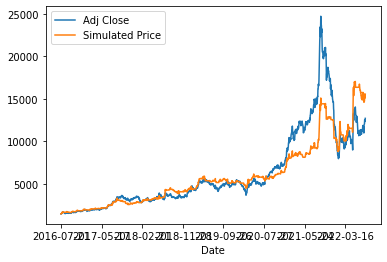

In [74]:
plotPerformance(pd.concat([df, df_val, df_test], axis=0))

In [11]:
def runAnalysis(df, title):
    df, df_val, df_test = splitData(df)
    print("Train, Val, Test split")
    print(len(df), len(df_val), len(df_test))
    best_cols = getBestColumns(df)
    _, test_mask = scoreCombinations(df, best_cols)
    print("Done")
    using = []
    for mask, colName in zip(test_mask, best_cols):
        if mask == 1:
            using.append(colName)
    print("Combining momentum predictions from", using)
    print("Test Accuracy:", testCombo(test_mask, df_test, best_cols))
    plotPerformance(df_test, best_cols, test_mask, title)
    plotPerformance(pd.concat([df_val, df_test], axis=0), best_cols, test_mask, title)
    plotPerformance(pd.concat([df, df_val, df_test], axis=0), best_cols, test_mask, title)

In [12]:
def normalize_col(arr, col):
    mx, mn = np.max(arr), np.min(arr)
    norm = [-21]
    if mx - mn > 20:
#         print(col, "norm diff", arr[:5])
        for i in range(1, len(arr)):
            if arr[i]>arr[i-1]:
                norm.append(1)
            elif arr[i]<arr[i-1]:
                norm.append(-1)
            else:
                norm.append(0)
    elif mn >=0:
#         print(col, "norm 0 -> 1 snap", arr[:5])
        for i in range(1, len(arr)):
            if arr[i] > 0:
                norm.append(1)
            else:
                norm.append(-1)
    else:
#         print(col, "norm -1 -> 1 snap", arr[:5])
        for i in range(1, len(arr)):
            if arr[i] > 0:
                norm.append(1)
            elif arr[i] < 0:
                norm.append(-1)
            else:
                norm.append(0)
    return np.array(norm)

In [13]:
def proccessData(df):
    df.dropna(inplace=True, how='any')
    df.reset_index(drop=True, inplace=True)
    indicators="""ao
    apo
    bias
    bop
    brar
    cci
    cfo
    cg
    cmo
    coppock
    cti
    dm
    er
    eri
    fisher
    inertia
    kdj
    kst
    macd
    mom
    pgo
    ppo
    psl
    pvo
    qqe
    roc
    rsi
    rsx
    rvgi
    stc
    slope
    smi
    squeeze
    squeeze_pro
    stoch
    stochrsi
    trix
    tsi
    uo
    willr"""
    CustomStrategy = ta.Strategy(
        name="Momentums",
        description="Bunch of different momentum measurements",
        ta=[
            {"kind": ind} for ind in indicators.split()
        ]
    )
    df.ta.strategy(CustomStrategy)
    
    if len(df) > 1500:
        df= df[-1500:]
    else:
        df = df[50:]
    
    df.dropna(axis=1, inplace=True, how='any')
    df["Date"] = pd.to_datetime(df["Date"])
    
    columns = df.columns
    for col in columns[7:]:
        df[col] = normalize_col(df[col].to_numpy(), col)
    df = df[1:]
    df.reset_index(drop=True, inplace=True)

    return df

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
1199 150 150
Best so far 0.4941569282136895 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.508347245409015 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5300500834724541 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5326633165829145 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5372384937238494 array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5381391450125733 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])
Best so far 0.5392320534223706 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])
Done
Combining momentum predictions from ['PVOs_12_26_9', 'SQZ_20_2.0_20_1.5', 'SQZPRO_20_2.0_20_2_1.5_1', 'RSX_14', 'TRIXs_30_9', 'PVOh_12_26_9', 'STCmacd_10_12_26_0.5']
Test Accuracy: 0.5503355704697986
[-1  1  1  1 -1  1 -1  1 

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


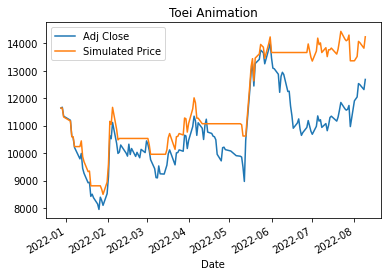

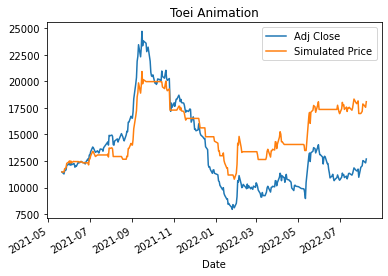

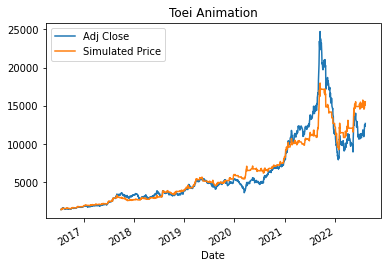

In [18]:
df = pd.read_csv('./4816.T.csv')
processed = proccessData(df)
runAnalysis(processed, "Toei Animation")

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
950 119 119
Best so far 0.541622760800843 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5489989462592202 array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5669125395152792 array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5742887249736565 array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
Done
Combining momentum predictions from ['DMN_14', 'PPOh_12_26_9', 'SQZPRO_ON_WIDE', 'SQZ_NO', 'TRIX_30_9']
Test Accuracy: 0.5508474576271186
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1 -1  1 -1 -1 -1  1
 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1
  1 -1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1 -1 -1]
Trades Made 38
[ 1 -1 -1 -1 -1 -1 -1 -1 

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


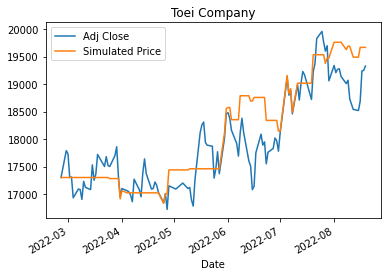

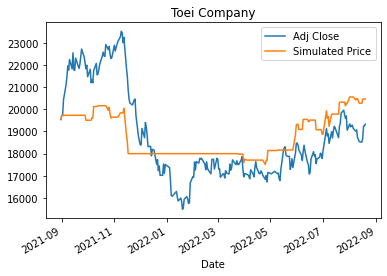

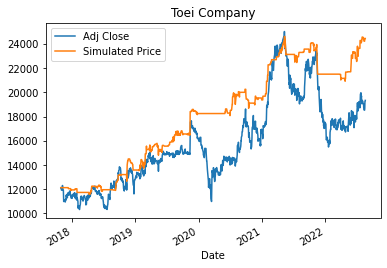

In [19]:
df = pd.read_csv('./9605.T.csv')
processed = proccessData(df)
runAnalysis(processed, "Toei Company")

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
1199 150 150
Best so far 0.5175292153589316 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5208681135225376 array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5217028380634391 array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5225375626043406 array([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5250417362270451 array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5267111853088481 array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5275459098497496 array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5283806343906511 array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5300500834724541 array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.53338

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


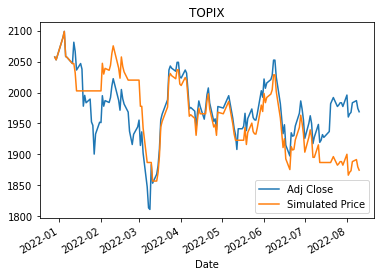

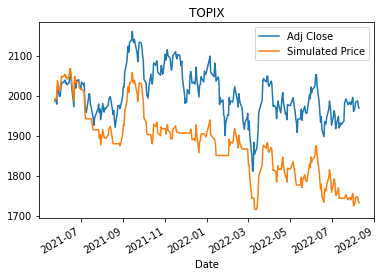

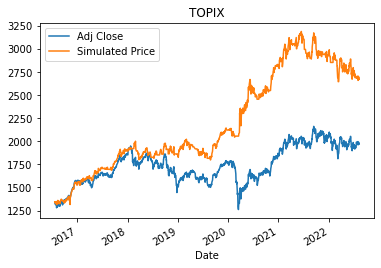

In [20]:
df = pd.read_csv('./1308.T.csv')
processed = proccessData(df)
runAnalysis(processed, 'TOPIX')

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
1199 150 150
Best so far 0.5350584307178631 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5392320534223706 array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5425709515859767 array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5442404006677797 array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5450751252086812 array([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5467445742904842 array([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5500834724540902 array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
Done
Combining momentum predictions from ['ER_10', 'PVOs_12_26_9', 'SQZPRO_OFF', 'PVO_12_26_9', 'APO_12_26', 'MACDs_12_26_9', 'RSX_14']
Test Accuracy: 0.5503355704697986
[ 1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1  

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


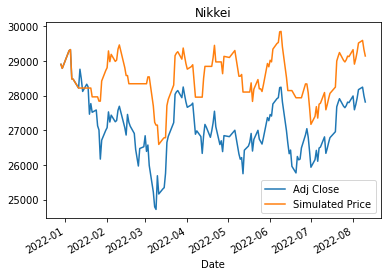

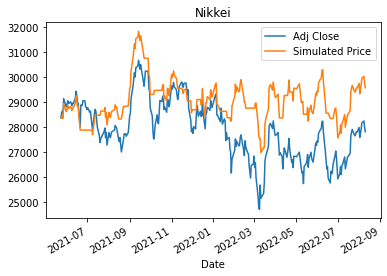

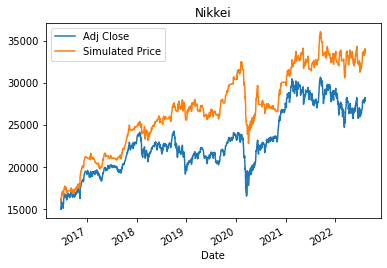

In [21]:
df = pd.read_csv('./^N225.csv')
processed = proccessData(df)
runAnalysis(processed, 'Nikkei')

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
966 121 120
Best so far 0.5544041450777202 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.555440414507772 array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5616580310880829 array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5678756476683938 array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5709844559585492 array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.572020725388601 array([1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5730569948186528 array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5736514522821576 array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5746887966804979 array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.57512953

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


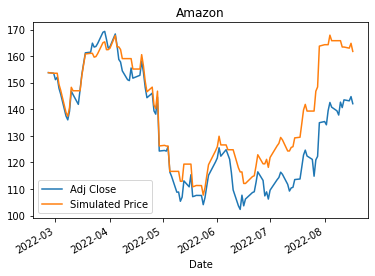

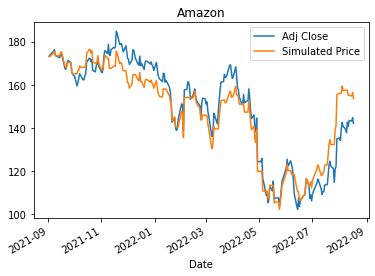

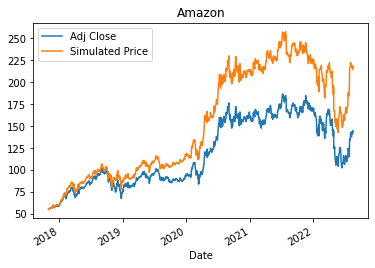

In [22]:
df = pd.read_csv('./AMZN.csv')
processed = proccessData(df)
runAnalysis(processed, 'Amazon')

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
966 121 120
Best so far 0.5398963730569948 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5419689119170984 array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.550259067357513 array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5512953367875648 array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])
Best so far 0.5533678756476684 array([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])
Best so far 0.5544041450777202 array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0])
Best so far 0.5564766839378238 array([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1])
Done
Combining momentum predictions from ['STCmacd_10_12_26_0.5', 'ER_10', 'DMP_14', 'DMN_14', 'PPOs_12_26_9', 'TSIs_13_25_13', 'PVOh_12_26_9', 'MACDh_12_26_9', 'SQZ_OFF']
Test Accuracy: 0.5294117647058824
[ 1  1  1 -1 -1 -1  1  1 

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


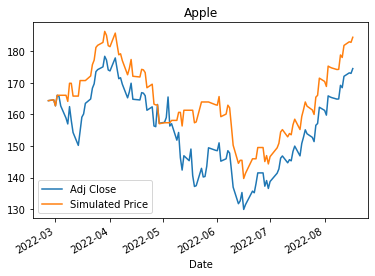

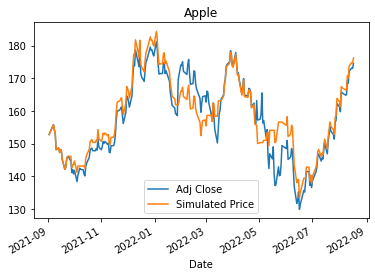

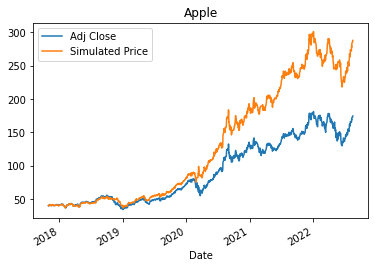

In [23]:
df = pd.read_csv('./AAPL.csv')
processed = proccessData(df)
runAnalysis(processed, 'Apple')

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
966 121 120
Best so far 0.5544041450777202 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5564766839378238 array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5575129533678757 array([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5606217616580311 array([1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])
Best so far 0.5647668393782384 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
Best so far 0.5678756476683938 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])
Best so far 0.5740932642487047 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])
Done
Combining momentum predictions from ['ER_10', 'DMP_14', 'PVOh_12_26_9', 'AR_26', 'CCI_14_0.015']
Test Accuracy: 0.5126050420168067
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1
  1 -1  1 -1  1 -1 -1

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


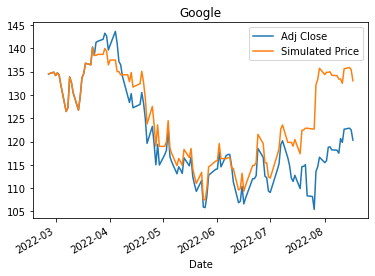

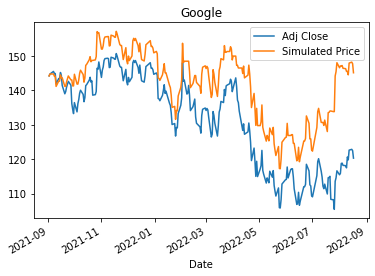

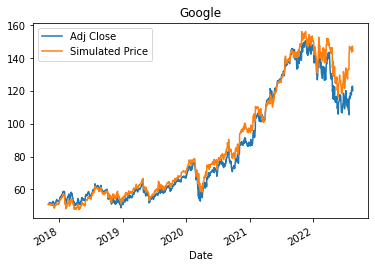

In [24]:
df = pd.read_csv('./GOOG.csv')
processed = proccessData(df)
runAnalysis(processed, 'Google')

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
966 121 120
Best so far 0.5243523316062176 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5347871235721703 array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5363825363825364 array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5373443983402489 array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5379023883696781 array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5394190871369294 array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5399792315680166 array([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5404564315352697 array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5441329179646937 array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.544224

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


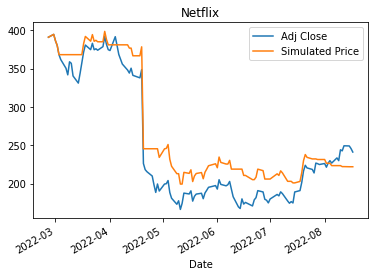

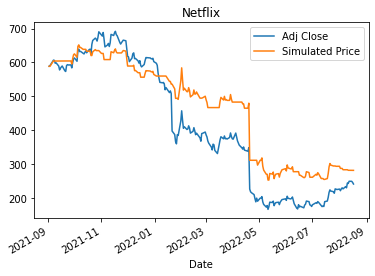

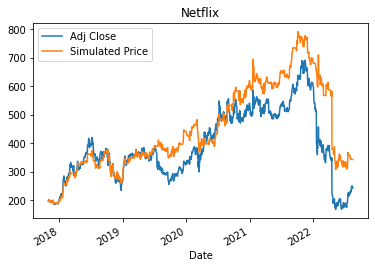

In [25]:
df = pd.read_csv('./NFLX.csv')
processed = proccessData(df)
runAnalysis(processed, 'Netflix')

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
966 121 120
Best so far 0.5461139896373057 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5471502590673575 array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5523316062176166 array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5533678756476684 array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5544041450777202 array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5575129533678757 array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Best so far 0.5595854922279793 array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Done
Combining momentum predictions from ['SMIs_5_20_5', 'CTI_12', 'FISHERT_9_1', 'TRIXs_30_9', 'ER_10']
Test Accuracy: 0.5042016806722689
[-1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1

C:\Users\anjur\AppData\Local\Temp\ipykernel_29732\816672442.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Simulated Price"] = sim_price


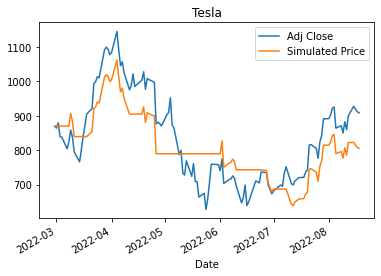

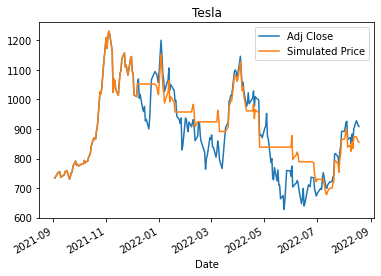

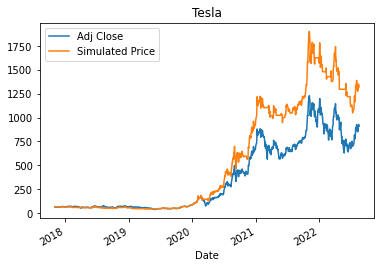

In [27]:
df = pd.read_csv('./TSLA.csv')
processed = proccessData(df)
runAnalysis(processed, 'Tesla')